In [2]:
import os 
import pandas as pd 
import seaborn as sns

In [3]:
# standard libraries
import pandas as pd
import matplotlib.pyplot as plt

# PySpark libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
from pyspark.sql.types import * 
from pyspark.sql.functions import to_date
from pyspark.sql.functions import col, avg

# DL/ML libraries
from sklearn.metrics import accuracy_score
spark = SparkSession.builder.getOrCreate()

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import unix_timestamp

In [5]:
filepath = "gs://bucket-sum-mg/csv/"

In [9]:
!ls

bin   copyright  etc	 home  lib64	   media  opt	root  sbin  sys  usr
boot  dev	 hadoop  lib   lost+found  mnt	  proc	run   srv   tmp  var


In [5]:
!hadoop fs -mkdir -p /csv
!gsutil -m cp -r gs://bucket-sum-mg/csv/* .
!hadoop fs -put -f *.csv /csv/

Copying gs://bucket-sum-mg/csv/allergies.csv...
Copying gs://bucket-sum-mg/csv/devices.csv...                                   
Copying gs://bucket-sum-mg/csv/careplans.csv...                                 
Copying gs://bucket-sum-mg/csv/conditions.csv...                                
Copying gs://bucket-sum-mg/csv/medications.csv...
Copying gs://bucket-sum-mg/csv/encounters.csv...                                
Copying gs://bucket-sum-mg/csv/immunizations.csv...                             
Copying gs://bucket-sum-mg/csv/imaging_studies.csv...                           
Copying gs://bucket-sum-mg/csv/observations.csv...                              
Copying gs://bucket-sum-mg/csv/organizations.csv...                             
Copying gs://bucket-sum-mg/csv/patients.csv...                                  
Copying gs://bucket-sum-mg/csv/payer_transitions.csv...                         
Copying gs://bucket-sum-mg/csv/payers.csv...e                                   
Copying gs:

In [6]:
path = "hdfs://st446-sum-mg-m:8020/csv/"

In [7]:
#patient 
observations = spark.read.csv(path+"observations.csv", header=True)
patient = spark.read.csv(path+"patients.csv", header=True) #includes healthcare coverage 

#medical 
careplans = spark.read.csv(path+"careplans.csv", header=True)
conditions = spark.read.csv(path+"conditions.csv", header=True)
procedures=spark.read.csv(path+"procedures.csv", header=True)
encounters = spark.read.csv(path+"encounters.csv", header=True)
medications = spark.read.csv(path+"medications.csv", header=True)

#insurance and hospital  
payer_transitions=spark.read.csv(path+"payer_transitions.csv", header=True)
payers=spark.read.csv(path+"payers.csv", header=True)
providers=spark.read.csv(path+"providers.csv", header=True)

#no need 
#supplies=spark.read.csv(path+"supplies.csv", header=True)
#allergies = spark.read.csv(path+"allergies.csv", header=True)
#devices = spark.read.csv(path+"devices.csv", header=True)
#imaging = spark.read.csv(path+"imaging_studies.csv", header=True)
#immunizations = spark.read.csv(path+"immunizations.csv", header=True)


In [ ]:
careplans.show(1)
conditions.show(1)
procedures.show(1)
encounters.show(3)

In [8]:
patient=patient.withColumnRenamed("Id","patient_id")

encounters=encounters.withColumnRenamed("PATIENT","patient_id")
encounters=encounters.withColumnRenamed("Id","encounter_id")
encounters=encounters.withColumnRenamed("DESCRIPTION","encounter_discription")
encounters=encounters.withColumnRenamed("CODE","encounter_code")
encounters=encounters.withColumnRenamed("START","encounter_start")
encounters = encounters.withColumn("encounter_start", to_date("encounter_start"))
encounters=encounters.withColumnRenamed("STOP","encounter_stop")
encounters = encounters.withColumn("encounter_stop", to_date("encounter_stop"))

careplans=careplans.withColumnRenamed("PATIENT","patient_id")
careplans=careplans.withColumnRenamed("Id","careplan_id")
careplans=careplans.withColumnRenamed("ENCOUNTER","encounter_id")
careplans=careplans.withColumnRenamed("DESCRIPTION","careplan_descriptions")
careplans=careplans.withColumnRenamed("CODE","careplan_code")

procedures=procedures.withColumnRenamed("PATIENT","patient_id")
procedures=procedures.withColumnRenamed("ENCOUNTER","encounter_id")
procedures=procedures.withColumnRenamed("DESCRIPTION","procedure_descriptions")
procedures=procedures.withColumnRenamed("CODE","procedure_code")
procedures=procedures.withColumnRenamed("DATE","procedure_date")
procedures=procedures.withColumnRenamed("BASE_COST","procedure_cost")

conditions=conditions.withColumnRenamed("PATIENT","patient_id")
conditions=conditions.withColumnRenamed("ENCOUNTER","encounter_id")
conditions=conditions.withColumnRenamed("DESCRIPTION","condition_description")
conditions=conditions.withColumnRenamed("CODE","condition_code")
conditions=conditions.withColumnRenamed("START","condition_start")
conditions=conditions.withColumnRenamed("END","condition_end")

observations=observations.withColumnRenamed("PATIENT","patient_id")
observations=observations.withColumnRenamed("ENCOUNTER","encounter_id")
observations=observations.withColumnRenamed("DATE","observation_date")
observations = observations.withColumn("observation_date", to_date("observation_date"))


In [60]:
payer_transitions.show(1)

+--------------------+----------+--------+--------------------+---------+
|             PATIENT|START_YEAR|END_YEAR|               PAYER|OWNERSHIP|
+--------------------+----------+--------+--------------------+---------+
|1d604da9-9a81-4ba...|      1989|    1998|b1c428d6-4f07-31e...| Guardian|
+--------------------+----------+--------+--------------------+---------+
only showing top 1 row



In [9]:
medications=medications.withColumnRenamed("START","medication_start")
medications = medications.withColumn("medication_start", to_date("medication_start"))
medications=medications.withColumnRenamed("STOP","medication_stop")
medications = medications.withColumn("medication_stop", to_date("medication_stop"))
medications=medications.withColumnRenamed("PATIENT","patient_id")
medications=medications.withColumnRenamed("PAYER","payer_id")
medications=medications.withColumnRenamed("ENCOUNTER","encounter_id")
medications=medications.withColumnRenamed("CODE","medication_code")
medications=medications.withColumnRenamed("DESCRIPTION","medication_description")

payer_transitions=payer_transitions.withColumnRenamed("PATIENT","patient_id")
payer_transitions=payer_transitions.withColumnRenamed("PAYER","payer_id")

payers=payers.withColumnRenamed("Id","payer_id")

providers=providers.withColumnRenamed("Id","provider_id")

In [50]:
payer_transitions.show(1)

+--------------------+----------+--------+--------------------+---------+
|             PATIENT|START_YEAR|END_YEAR|               PAYER|OWNERSHIP|
+--------------------+----------+--------+--------------------+---------+
|1d604da9-9a81-4ba...|      1989|    1998|b1c428d6-4f07-31e...| Guardian|
+--------------------+----------+--------+--------------------+---------+
only showing top 1 row



In [11]:
#merge patient and conditions
patient_conditions = patient.join(
    conditions,
    on="patient_id",
    how="left"
).select(
    "patient_id", "BIRTHDATE", "GENDER", "ZIP", 
    "encounter_id", "condition_code", "condition_description", "condition_start"  
)

#my df is missing the column income. will change it 

In [23]:
patient_conditions.show(1)

+--------------------+----------+------+-----+--------------------+--------------+---------------------+---------------+
|          patient_id| BIRTHDATE|GENDER|  ZIP|        encounter_id|condition_code|condition_description|condition_start|
+--------------------+----------+------+-----+--------------------+--------------+---------------------+---------------+
|1d604da9-9a81-4ba...|1989-05-25|     M|01013|4e595f0c-f50f-461...|     444814009| Viral sinusitis (...|     2019-03-20|
+--------------------+----------+------+-----+--------------------+--------------+---------------------+---------------+
only showing top 1 row



In [29]:
procedures.show(1)

+--------------------+--------------------+--------------------+--------------+----------------------+--------------+----------+-----------------+
|      procedure_date|          patient_id|        encounter_id|procedure_code|procedure_descriptions|procedure_cost|REASONCODE|REASONDESCRIPTION|
+--------------------+--------------------+--------------------+--------------+----------------------+--------------+----------+-----------------+
|2011-04-30T00:26:23Z|8d4c4326-e9de-4f4...|6aa37300-d1b4-48e...|     169553002|  Insertion of subc...|      14896.56|      NULL|             NULL|
+--------------------+--------------------+--------------------+--------------+----------------------+--------------+----------+-----------------+
only showing top 1 row



In [12]:
#patient procedure 
patient_procedures = patient.join(
    procedures,
    on="patient_id",
    how="left"
).select(
    "patient_id", "BIRTHDATE", "GENDER", "ZIP", 
    "encounter_id", "procedure_code", "procedure_descriptions", "procedure_date","procedure_cost","REASONCODE","REASONDESCRIPTION"  
)

In [32]:
patient_procedures.show(1)

+--------------------+----------+------+-----+--------------------+--------------+----------------------+--------------------+--------------+----------+-----------------+
|          patient_id| BIRTHDATE|GENDER|  ZIP|        encounter_id|procedure_code|procedure_descriptions|      procedure_date|procedure_cost|REASONCODE|REASONDESCRIPTION|
+--------------------+----------+------+-----+--------------------+--------------+----------------------+--------------------+--------------+----------+-----------------+
|1d604da9-9a81-4ba...|1989-05-25|     M|01013|de573182-8235-4b1...|     430193006|  Medication Reconc...|2017-08-03T15:02:18Z|        416.69|      NULL|             NULL|
+--------------------+----------+------+-----+--------------------+--------------+----------------------+--------------------+--------------+----------+-----------------+
only showing top 1 row



In [13]:
#observation to patient_procedure 
patient_procedures_observ = patient_procedures.join(
    observations,
    on=["patient_id","encounter_id"],
    how="left"
)

In [85]:
#observation to patient_procedure 
payer_transitions.show(1)

+--------------------+----------+--------+--------------------+---------+
|          patient_id|START_YEAR|END_YEAR|            payer_id|OWNERSHIP|
+--------------------+----------+--------+--------------------+---------+
|1d604da9-9a81-4ba...|      1989|    1998|b1c428d6-4f07-31e...| Guardian|
+--------------------+----------+--------+--------------------+---------+
only showing top 1 row



In [77]:
payers.show(1)

+--------------------+-------------+------------------+---------+-------------------+-----+--------------+--------------+----------------+----------+------------------+--------------------+-------------------+---------------------+------------------+--------------------+---------------------+-----------------------+----------------+-------------------+-------------+
|            payer_id|         NAME|           ADDRESS|     CITY|STATE_HEADQUARTERED|  ZIP|         PHONE|AMOUNT_COVERED|AMOUNT_UNCOVERED|   REVENUE|COVERED_ENCOUNTERS|UNCOVERED_ENCOUNTERS|COVERED_MEDICATIONS|UNCOVERED_MEDICATIONS|COVERED_PROCEDURES|UNCOVERED_PROCEDURES|COVERED_IMMUNIZATIONS|UNCOVERED_IMMUNIZATIONS|UNIQUE_CUSTOMERS|           QOLS_AVG|MEMBER_MONTHS|
+--------------------+-------------+------------------+---------+-------------------+-----+--------------+--------------+----------------+----------+------------------+--------------------+-------------------+---------------------+------------------+------------

### Average duration of coverage per payer 

In [14]:
#find the duration of coverage per payer for each patient
payer_transitions_with_duration = payer_transitions.withColumn(
    "coverage_duration", col("END_YEAR") - col("START_YEAR")
)

#find the average duration of coverage per payer 
avg_duration_per_payer = payer_transitions_with_duration.groupBy("payer_id").agg(
    avg("coverage_duration").alias("avg_coverage_years")
)

#group to get payer info
avg_duration_per_payer_info = avg_duration_per_payer.join(
    payers,
    on="payer_id",
    how="left"
).select(
    "payer_id", "NAME","CITY" ,"ZIP","avg_coverage_years"
).orderBy(col("avg_coverage_years").desc())

In [97]:
avg_duration_per_payer_info.show()

+--------------------+--------------------+------------+-----+------------------+
|            payer_id|                NAME|        CITY|  ZIP|avg_coverage_years|
+--------------------+--------------------+------------+-----+------------------+
|b3221cfc-24fb-339...|       Dual Eligible|   Baltimore|21244|             50.08|
|7caa7254-5050-3b5...|            Medicare|   Baltimore|21244|31.995670995670995|
|047f6ec3-6215-35e...|        Cigna Health|  Bloomfield| 6002| 7.610062893081761|
|42c4fca7-f8a9-3cd...|              Anthem|Indianapolis|46204| 7.138513513513513|
|5059a55e-5d6e-34d...|    UnitedHealthcare|  Minnetonka|55436| 7.105882352941176|
|d47b3510-2895-3b7...|              Humana|  Louisville|40018| 6.840390879478828|
|4d71f845-a6a9-3c3...|               Aetna|    Hartford| 6156| 6.542763157894737|
|6e2f1a2d-27bd-370...|Blue Cross Blue S...|     Chicago|60007| 6.340909090909091|
|7c4411ce-02f1-39b...|            Medicaid|   Baltimore|21244|4.2076271186440675|
|b1c428d6-4f07-3

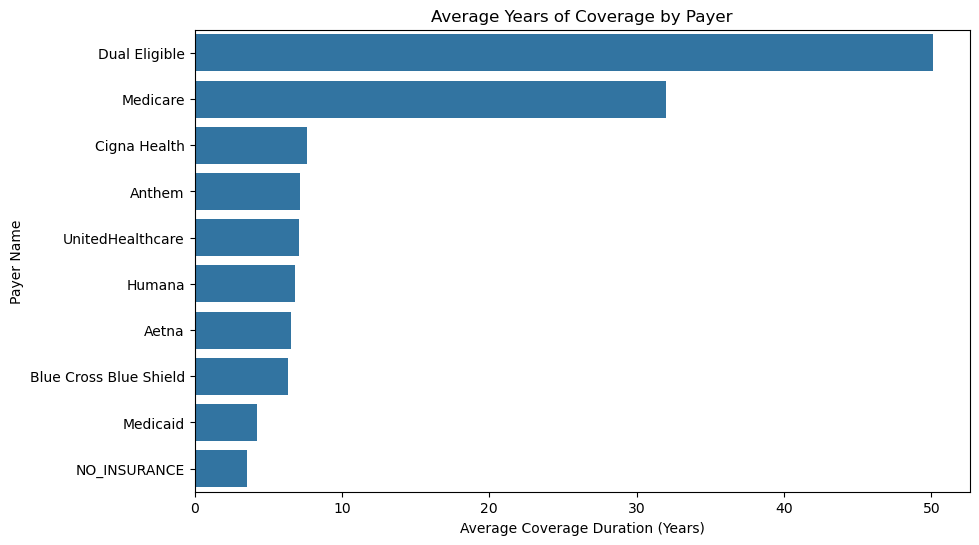

In [15]:
avg_duration_pd = avg_duration_per_payer_info.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_duration_pd,
    x="avg_coverage_years",
    y="NAME"
)
plt.xlabel("Average Coverage Duration (Years)")
plt.ylabel("Payer Name")
plt.title("Average Years of Coverage by Payer")
plt.show()

### Average length of encounters

In [10]:
from pyspark.sql.functions import to_timestamp, unix_timestamp, avg

In [11]:
#first change encounter timestamps 
encounters = encounters.withColumn("encounter_start", to_timestamp("encounter_start"))
encounters = encounters.withColumn("encounter_stop", to_timestamp("encounter_stop"))

In [12]:
encounters_with_duration = encounters.withColumn("encounter_duration", 
    (unix_timestamp("encounter_stop") - unix_timestamp("encounter_start")) / 3600
)

avg_encounter_duration = encounters_with_duration.groupBy("PAYER").agg(
    avg("encounter_duration").alias("avg_encounter_hours")
)

avg_encounter_duration_info = avg_encounter_duration.join(
    payers, on=avg_encounter_duration["PAYER"] == payers["payer_id"], how="left"
).select(
    "payer_id", "NAME", "CITY", "ZIP", "avg_encounter_hours"
).orderBy(col("avg_encounter_hours").desc())


In [36]:
encounters_with_duration .show()

+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------------------+-------------------+----------------+--------------+----------+--------------------+------------------+
|        encounter_id|    encounter_start|     encounter_stop|          patient_id|        ORGANIZATION|            PROVIDER|               PAYER|ENCOUNTERCLASS|encounter_code|encounter_discription|BASE_ENCOUNTER_COST|TOTAL_CLAIM_COST|PAYER_COVERAGE|REASONCODE|   REASONDESCRIPTION|encounter_duration|
+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------+---------------------+-------------------+----------------+--------------+----------+--------------------+------------------+
|d0c40d10-8d87-447...|2010-01-23 00:00:00|2010-01-23 00:00:00|034e9e3b-2def-455...|e002090d-4e

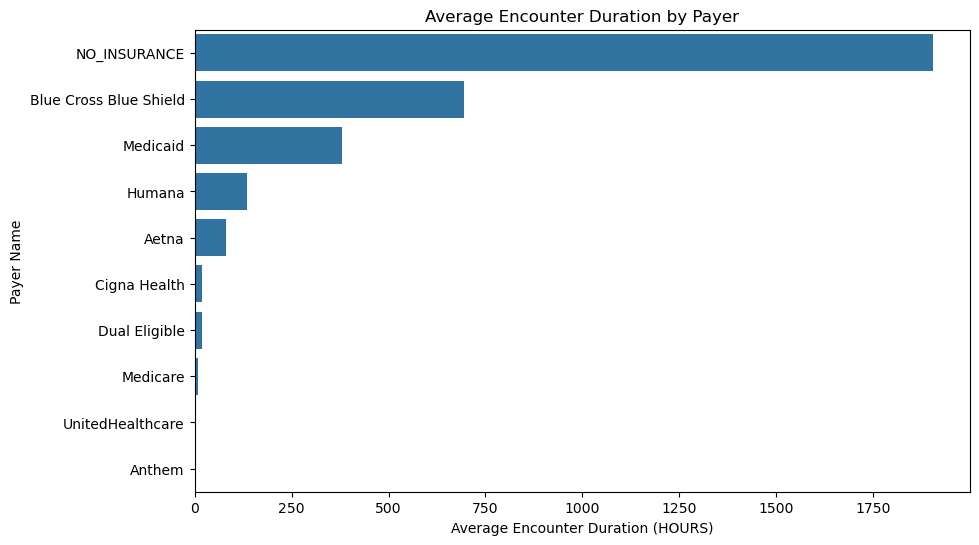

In [13]:
avg_encounter_pd = avg_encounter_duration_info.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_encounter_pd,
    x="avg_encounter_hours",
    y="NAME"
)
plt.xlabel("Average Encounter Duration (HOURS)")
plt.ylabel("Payer Name")
plt.title("Average Encounter Duration by Payer")
plt.show()

In [15]:
reason_labels = encounters.select("REASONCODE", "REASONDESCRIPTION").dropna().dropDuplicates()

avg_encounter_duration_reason = encounters_with_duration.groupBy("REASONCODE").agg(
    avg("encounter_duration").alias("avg_encounter_hours_reason")
)

avg_encounter_reason=avg_encounter_duration_reason .join(
    reason_labels,on="REASONCODE",how="left"
).select(
    "REASONCODE", "REASONDESCRIPTION","avg_encounter_hours_reason"
).orderBy(col("avg_encounter_hours_reason").desc())

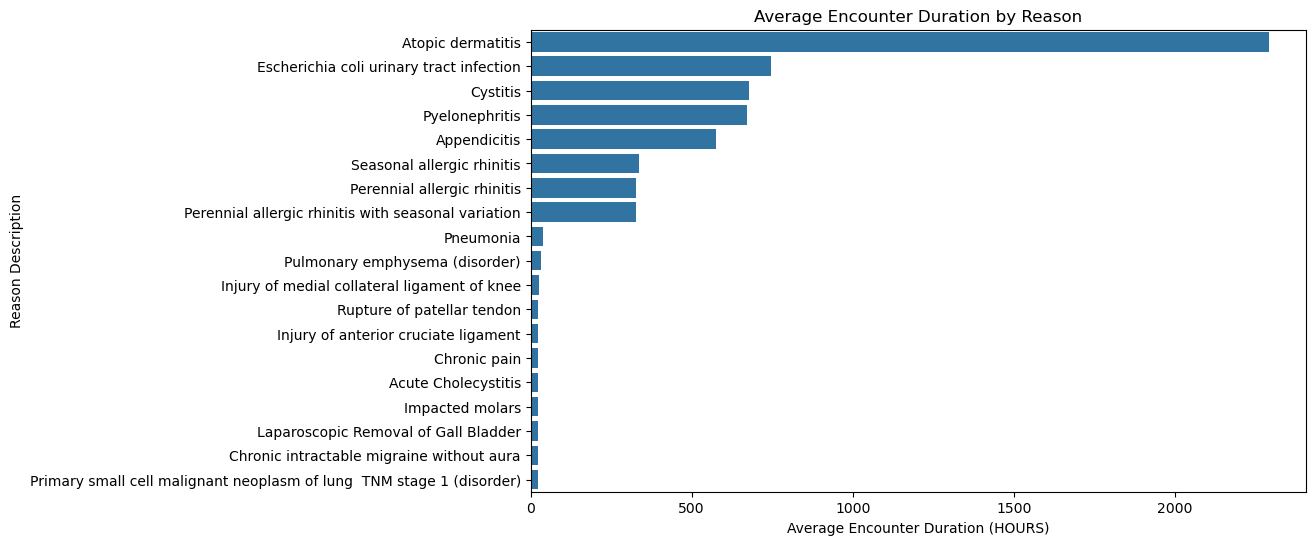

In [18]:
#show top 20 reasons
avg_encounter_reason_pd = avg_encounter_reason.toPandas().head(20)
plt.figure(figsize=(10,6))
sns.barplot(
    data=avg_encounter_reason_pd,
    x="avg_encounter_hours_reason",
    y="REASONDESCRIPTION"
)
plt.xlabel("Average Encounter Duration (HOURS)")
plt.ylabel("Reason Description")
plt.title("Average Encounter Duration by Reason")
plt.show(20)